In [1]:
push!(LOAD_PATH, pwd()) # put current directory on path
using Revise, UnPack, Plots, DifferentialEquations, ForwardDiff, LaTeXStrings, LinearAlgebra
using CooperativeHuntingPkg

# plot defaults:
default(
    guidefontsize=14,   # controls xlabel, ylabel, title font size
    tickfontsize=12,    # controls axis number labels
    legendfontsize=14,  # controls legend font
    linewidth=2,        # controls default line thickness
    grid = false,        # turns off grid in background
    dpi = 200,
    fontfamily="Computer Modern" # font family that matches latex
)
using Polynomials
fig_path = "/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/SimpleW/"



"/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/SimpleW/"

In [2]:
function fun_W_gauss(x, p)
    @unpack a, x0, σ = p # height, x that maximizes fecundity, standard deviation
    W = a .* exp.( - (x .- x0).^2 ./(2*σ^2))
end

function fun_dg_weird!(dg, g, p, T)
#= 
group dynamics only using gaussian W, no pairs fusing
=#
    # p - parameters - has a, x0, σ, Tg, d, and x_max

    # unpack basic ingredients
    @unpack x_max, Tg = p
    xvec = 1:x_max

    # i'll need fitnesses and best response functions
    Wvec = fun_W_gauss(xvec, p) 
    W1 = Wvec[1]
    S_1_x = fun_S_given_W(Wvec[1],Wvec, p)
    for x in xvec
        if x==1
            if x_max == 1
                groups_2_split = 0
                join_groups = 0
                leave_larger_grps = 0
            else
                groups_2_split = 4*g[2]*S_1_x[2]/Tg
                join_groups = -(g[1]/Tg)*sum(g[2:end-1].*(1 .- S_1_x[3:end]))
                if x_max > 2
                    leave_larger_grps = sum(xvec[3:end].*g[3:end].*S_1_x[3:end])/Tg
                else
                    leave_larger_grps = 0
                end
            end
            dg[1] = groups_2_split + leave_larger_grps + join_groups

        elseif x == 2
            individual_leaves = - 2*g[2]*S_1_x[2]/Tg
            if x_max == 2
                threes_to_pairs = 0
                pairs_to_threes = 0
            else
                pairs_to_threes = - g[2]*g[1]*(1-S_1_x[3])/Tg
                threes_to_pairs = 3*g[3]*S_1_x[3]/Tg
                # deaths = td * (3*g[3] - 2*g[2])
                # births = g[1]*Wvec[1] - 2*g[2]*Wvec[2]
            end
            form_dyads = 0 # (g[1])^2*(1-S_1_x[2])/(2*Tg)
            dg[2] = (individual_leaves + pairs_to_threes + form_dyads + threes_to_pairs
                )

        elseif x == x_max
            individual_leaves = - x*g[x]*S_1_x[x]/Tg
            smaller_grp_grows_to_xm  = g[x-1]*g[1]*(1-S_1_x[x])/Tg
            dg[x] = (individual_leaves + smaller_grp_grows_to_xm )

        else
            individual_leaves = -(x/Tg)*g[x]*S_1_x[x]
            grows_to_larger_grp = - g[x]*g[1]*(1 - S_1_x[x+1])/Tg
            smaller_grp_grows_to_x = g[x-1]*g[1]*(1-S_1_x[x])/Tg
            larger_grps_shrink = (x+1)*g[x+1]*S_1_x[x+1]/Tg
            dg[x] = (individual_leaves + grows_to_larger_grp + smaller_grp_grows_to_x
                + larger_grps_shrink )
            
        end
        # do something with x 
    end
end


function plot_W(W, i, label)
    Wabove = W[W .> W[1]]
    x_end_above = findlast(>(W[1]),W)
    plot!(
        1:x_end_above+1, W[1:x_end_above+1], 
        color = i, marker = :circle,
        label = label)
    plot!(
        x[x_end_above+1:end],W[x_end_above+1:end], 
        color = i, marker = :circle, linestyle = :dot, 
        markerstrokecolor = i,
        markercolor = :white,
        label = "")
end

params_base = Dict(
    :a => 2,
    :σ => 1,
    :x0 => 5,
    :Tg => .01,
    :d => 100,
    :x_max => 15,
    :l => 0.5
)

Dict{Symbol, Real} with 7 entries:
  :a     => 2
  :Tg    => 0.01
  :x0    => 5
  :σ     => 1
  :d     => 100
  :x_max => 15
  :l     => 0.5

# Plot W

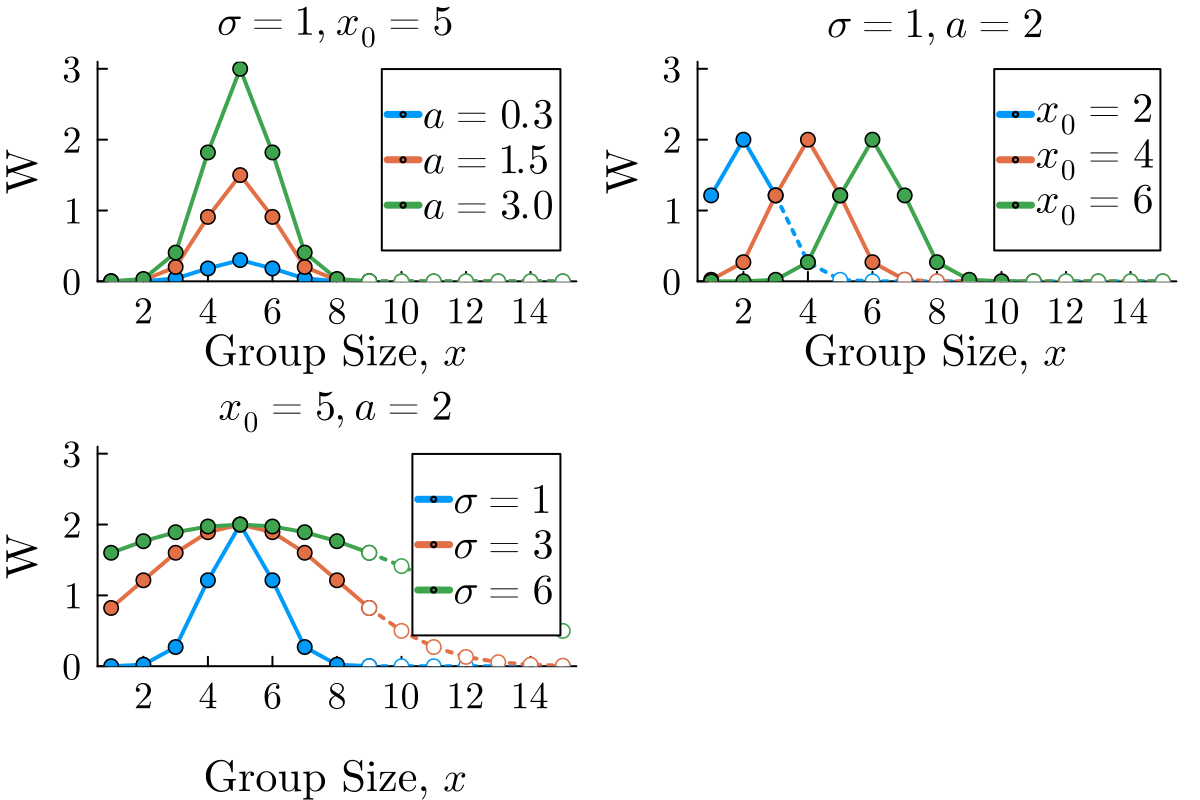

In [3]:
x = collect(1.0:1.0:15.0)




# vs a
a_list = [0.3, 1.5, 3.0]
params = deepcopy(params_base)
fig1 = plot()
for (i, a) in enumerate(a_list)
    params[:a] = a
    W = fun_W_gauss(x, params)
    plot_W(W, i, L"$a = %$a$")
    #plot!(x,W, color = i, marker = :circle, label = L"$A_1 = %$A1$")

end
@unpack σ, x0 = params

plot!(
    ylim=[0.0,3.1],
    xlab = L"Group Size, $x$",
    ylab = "W",#"W, per-capita fecundity",
    title = L"$\sigma = %$σ, x_0 = %$x0$")
#plot!(title = L"s_1 = 2.0, \alpha_1(1) = 0.05")
#savefig(fig, bif_fig_path*"simpleW_vs_A1.pdf")


# vs x0

x0_list = [2, 4, 6]
params = deepcopy(params_base)
fig2 = plot()
for (i, x0) in enumerate(x0_list)
    params[:x0] = x0
    W = fun_W_gauss(x, params)
    plot_W(W, i, L"$x_0= %$x0$")
    #plot!(x,W, color = i, marker = :circle, label = L"$A_1 = %$A1$")
end
@unpack σ, a = params
plot!(fig2,
    ylim=[0.0,3.1],
    xlab = L"Group Size, $x$",
    ylab = "W",#"W, per-capita fecundity",
    title = L"$\sigma = %$σ, a = %$a$")




# vs sigma 
σ_list = [1, 3, 6]
params = deepcopy(params_base)
fig3 = plot()
for (i, σ) in enumerate(σ_list)
    params[:σ] = σ
    W = fun_W_gauss(x, params)
    plot_W(W, i, L"$\sigma= %$σ$")
    #plot!(x,W, color = i, marker = :circle, label = L"$A_1 = %$A1$")

end
@unpack x0, a = params
plot!(fig3,
    ylim=[0.0,3.1],
    xlab = "\n"*L"Group Size, $x$",
    ylab = "W",#"W, per-capita fecundity",
    title = L"$x_0 = %$x0, a = %$a$")



plot(fig1, fig2 , fig3)


In [106]:
savefig(fig1, fig_path*"W_vary_a.pdf")
savefig(fig2, fig_path*"W_vary_x0.pdf")
savefig(fig3, fig_path*"W_vary_sigma.pdf")

"/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/SimpleW/W_vary_sigma.pdf"

# Example 1:  a = 2, x0 = 5, sigma = 1

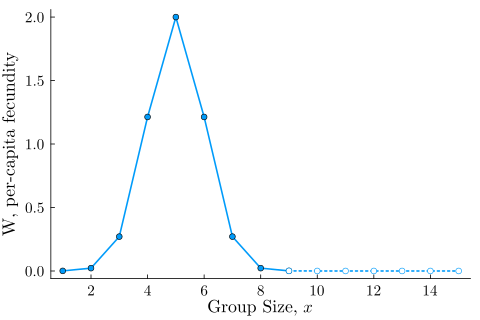

In [4]:
params = deepcopy(params_base)
W = fun_W_gauss(x, params)
fig = plot()
plot_W(W,1,"")
plot!(
    xlab = L"Group Size, $x$",
    ylab = "W, per-capita fecundity",
)
plot!(dpi = 80)

# Initial point with group of size 9 and many solitary individuals

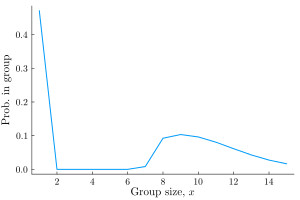

In [5]:
x_max = params[:x_max]
x = 1:x_max
W = fun_W_gauss(x, params)
x_mc =  findlast(>=(W[1]),W)
g0 = zeros(x_max)
g0[1] = 10.0
g0[x_mc] = 1.0
p = get_p(g0)

tspan = (0,1000)
prob = ODEProblem(fun_dg_weird!, g0, tspan, NamedTuple(params))
sol = solve(prob)

g = sol.u
gmat = hcat(g...)'
prob = get_prob_in_x(gmat, p, x_max)

plot(
    prob[end,:],
    xlabel = L"Group size, $x$",
    ylabel = "Prob. in group",
    label = "",
    dpi = 50)

    

# No leaving

# Modulate Singletons Fusing and Individuals Leaving

## Functions

In [ ]:
# function get_g_equilibria_givenW(P, W, params)
# #=
# This only works if leave_param and fuse_param == 1
# Finds all the g(x) equilibria for a certain p, N1, N2 combination.
# Assumes population sizes are constant.

# This can break down if S(x,1) is too close to 0, it depends on the curve. 

# Returns gvec
# =#
#     x_max = params[:x_max]
#     xvec = 1:x_max

#     # Get the root for g(1)

#     S_of_1_x = fun_S_given_W(W[1], W, params)
#     S_of_x_1 = 1 .- S_of_1_x
#     c_vec = S_of_x_1./(xvec.*S_of_1_x)
#     c_vec[2] = c_vec[2]/2    
#     # Compute coefficients for g(1)
#     coefficients = [x * prod(c_vec[1:x]) for x in xvec]  # Reverse order
#     coeff_full = vcat(-P, coefficients)  # Append -P to the coefficients
#     # Find roots
#     roots_all = roots(Polynomials.Polynomial(coeff_full))
    
#     # Filter real positive roots. there should only be one.
#     g1 = real(filter(x -> isreal(x) && real(x) > 0, roots_all)[1])

#     # Compute g(x) for each g1 root
#     gvec = [prod(c_vec[1:x]) * g1^x for x in xvec]

#     return gvec
# end


function bifurcation_g_input_simpleW(p, paramkey::Symbol, 
    paramvec, params_base::Dict{Symbol, Any})
#=
Loop over elements of paramvec, 
finding the g equilibrium and stability for each
paramater value
=#
    x_max = params_base[:x_max]
    # Initialize arrays to store equilibrium g values and their corresponding stability
    results_g = zeros(length(paramvec), x_max)  # 2D array
    stability_results = Vector{Bool}(undef, length(paramvec))
    xvec = 1:x_max
    params = deepcopy(params_base)

    # Iterate over paramvec
    for (i, param) in enumerate(paramvec)

        # Update parameters
        params[paramkey] = param

        # Find the single equilibrium g vector
        W = fun_W_gauss(xvec,params)
        gvec = get_g_equilibria_givenW(p, W, params)

        # Get stability
        stability = classify_equilibrium_g(gvec, N1, N2, params)

        # Store results
        results_g[i, :] = gvec  # Store the vector as a row
        stability_results[i] = stability
    end

    return Dict(
        :results_g => results_g, 
        :stability_results => stability_results
        )
end




function fun_dg_simpleW(g, p, T)
    dg = deepcopy(g)
    fun_dg_simpleW!(dg, g, p, T)
    return dg
end

function classify_equilibrium_g_simpleW(g, N1, N2, params)
#=  1
Compute the eigenvalues of the Jacobian matrix for just the dynamics of dg(x)/dt.
Returns:
- "Stable (attractive)"
- "Unstable"
- "Marginally stable (needs further analysis)"
- "Indeterminate stability (needs further analysis)"
=#
    # Compute the Jacobian matrix for group dynamics
    J = ForwardDiff.jacobian(u -> fun_dg_simpleW(u, params, 1),g[1:end-1])
    #J = Jacobian_g(N1, N2, g, params)

    # Compute the eigenvalues of the Jacobian matrix
    eigenvalues = eigen(J).values
    # Check the real parts of the eigenvalues
    real_parts = real.(eigenvalues)

    # Classify the stability based on the real parts of the eigenvalues
    if all(real_parts .< 0)
        return true
    else
        return false
    end
end

function get_g_equilibria_2_fromW(P, W, params)
#=
Finds all the g(x) equilibria for a certain P, W combination.

Assumes population sizes are constant.

LEAVE_PRAM, FUSE_PARAM == 1

This version does not have S(1,y) in the denominator
Returns gvec
=#
    x_max = params[:x_max]
    xvec = 1:x_max
    S_of_1_x = fun_S_given_W(W[1], W, params)
    S_of_x_1 = 1 .- S_of_1_x

    # set up vector of coefficients for polynomial
    coeff_full = zeros(x_max+1)

    # do first couple terms
    full_product = 2*prod(xvec .* S_of_1_x)
    coeff_full[1] = -P*full_product # constant term
    coeff_full[2] = full_product # coeff of g(1)

    # Compute coefficients for g(1) for the 3rd term to the xm + 2 term (corresponding to g(2), g(3),)
    coefficients = [
        x * prod(S_of_x_1[2:x]) * prod(xvec[x+1:end] .* S_of_1_x[x+1:end]) 
        for x in 2:(x_max - 1)
            ]  
    coeff_full[3:end-1] = coefficients
    coeff_full[end] = x_max * prod(S_of_x_1)

    # Find roots
    roots_all = roots(Polynomials.Polynomial(coeff_full))
    
    # Filter real positive roots. there should only be one.
    g1 = real(filter(x -> isreal(x) && real(x) > 0, roots_all)[1])


    c = S_of_x_1 ./ ( xvec .* S_of_1_x )
    # Compute g(x) for each g1 root
    gvec = [prod(c[1:x] .* g1 ) for x in xvec] # this seems to generally manage issue of infs

    return gvec
end


get_g_equilibria_2_fromW (generic function with 1 method)

In [3]:
params_base = Dict(
    :a => 2.0,
    :σ => 1,
    :x0 => 5,
    :Tg => .01,
    :d => 2,
    :x_max => 15,
    :leave_param => 1.0,
    :fuse_param => 1.0
)
P = 3.0

3.0

## With Leaving and Fusing

## More useful functions

In [67]:
function make_hm_versus_param(
    g0, paramkey, paramvec, params_base, ODE_fun_handle, W_fun_handle; 
    t_f = 500)
#=
Plot a heatmap of Pr(x) versus some parameter that's being varied
ODE_fun_handle gives the functions used to calculate dg. needs to be in place (with a ! at the end)
Keeping population size constant


This works without any scaling of parameters that has to be done every time params dic updated
=#
    @unpack x_max = params_base
    dg = zeros(x_max)
    P = get_p(g0, x_max)
    params = deepcopy(params_base)
    
    n = length(paramvec)
    pxmat = zeros(n, x_max)
    reached_equilibrium_vec = zeros(n)
    mean_x_vec = zeros(n)
    mc_x_vec = zeros(n)

    for (i,param) in enumerate(paramvec)
        params[paramkey] = param
        
        if ODE_fun_handle == fun_dg_simpleW!
            W = fun_W_gauss(1:x_max, params)
            g_final = get_g_equilibria_givenW(P, W, params)
        else
            prob = ODEProblem(ODE_fun_handle, g0, (0,t_f), NamedTuple(params))
            sol = solve(prob);
            g = sol.u;
            g_final = g[end]
        end
        px = get_prob_in_x(g_final, P, x_max)
        pxmat[i,:] = px

        ODE_fun_handle(dg, g_final, NamedTuple(params), 1.0)
        reached_equilibrium_vec[i] = all(abs.(dg) .< 1e-10)
        mean_x_vec[i] = get_meanx(g_final, x_max)

        # mangel and Clark
        W = W_fun_handle(1:x_max, params)
        mc_x_vec[i] = findlast(>=(W[1]),W)
    end

    xlabel_dict = Dict(
        :σ => L"Standard Deviation of $W$, $\sigma$",
        :a => L"Maximum Fitness Height, $a$",
        :x0 => L"Group Size that Maximizes Fitness, $x_0$",
    )
    hm = heatmap(
        paramvec,     # x = rows
        1:size(pxmat,2),     # y = columns
        pxmat',              # transpose so rows map to x
        c = cgrad(:grays, rev=true),    # high values → dark
        clims = (0.0, findmax(pxmat)[1]), #1.0), 
        #colorrev=false,      # darker = higher
        xlabel= xlabel_dict[paramkey],
        ylabel=L"Group size, $x$",
        #title=L"Probability heatmap; $x_0 = %$x0$, $a = %$a$"
    )
    plot!(paramvec, mean_x_vec, label = L"\bar{x}")
    plot!(paramvec, mc_x_vec, label = "Clark and Mangel")
    return hm, reached_equilibrium_vec
end



function fun_dg_simpleW_births_constantP!(dg, g, params, T)
    # p - parameters - has a, x0, σ, Tg, d, and x_max

    # unpack basic ingredients
    @unpack x_max, Tg, fuse_param, leave_param = params
    xvec = 1:x_max

    # i'll need fitnesses and best response functions
    Wvec = fun_W_gauss(xvec, params) 
    W1 = Wvec[1]
    S_1_x = fun_S_given_W(Wvec[1],Wvec, params)
    P = get_p(g, x_max)
    δ = sum( xvec .* Wvec .* g) ./ P
    for x in xvec
        if x==1
            if x_max == 1
                groups_2_split = 0
                join_groups = 0
                leave_larger_grps = 0
                births = g[1]*Wvec[1]
                deaths = - δ*g[1]
            else
                groups_2_split = 4*g[2]*S_1_x[2]/Tg
                join_groups = -(g[1]/Tg)*sum(g[2:end-1].*(1 .- S_1_x[3:end]))
                join_groups_singletonsfuse = - (g[1]./ Tg) .*g[1] .* (1 .- S_1_x[2]) 
                births = x_max*g[x_max]*Wvec[x_max] - g[1]*Wvec[1]
                deaths = 2*δ*g[2] - δ*g[1]
                if x_max > 2
                    leave_larger_grps = sum(xvec[3:end].*g[3:end].*S_1_x[3:end])/Tg
                else
                    leave_larger_grps = 0
                end
            end
            dg[1] = (leave_param * (groups_2_split + leave_larger_grps) + join_groups 
                        + fuse_param * join_groups_singletonsfuse + births + deaths)

        elseif x == 2
            individual_leaves = - 2*g[2]*S_1_x[2]/Tg
            if x_max == 2
                threes_to_pairs = 0
                pairs_to_threes = 0
                deaths = -2*δ*g[2]
                births = g[1]*Wvec[1]
            else
                pairs_to_threes = - g[2]*g[1]*(1-S_1_x[3])/Tg
                threes_to_pairs = 3*g[3]*S_1_x[3]/Tg
                deaths = δ * (3*g[3] - 2*g[2])
                births = g[1]*Wvec[1] - 2*g[2]*Wvec[2]
            end
            form_dyads = (g[1])^2*(1-S_1_x[2])/(2*Tg)
            dg[2] = (leave_param * (individual_leaves + threes_to_pairs) 
                    + pairs_to_threes + fuse_param * form_dyads
                    + births + deaths 
                )

        elseif x == x_max
            individual_leaves = - x*g[x]*S_1_x[x]/Tg
            smaller_grp_grows_to_xm  = g[x-1]*g[1]*(1-S_1_x[x])/Tg
            births = (x-1)*g[x-1]*Wvec[x-1]
            deaths = - δ * g[x] * x
            dg[x] = (leave_param * individual_leaves + smaller_grp_grows_to_xm 
                    + births + deaths)

        else
            individual_leaves = -(x/Tg)*g[x]*S_1_x[x]
            grows_to_larger_grp = - g[x]*g[1]*(1 - S_1_x[x+1])/Tg
            smaller_grp_grows_to_x = g[x-1]*g[1]*(1-S_1_x[x])/Tg
            larger_grps_shrink = (x+1)*g[x+1]*S_1_x[x+1]/Tg
            births = (x-1)*g[x-1]*Wvec[x-1] - x*g[x]*Wvec[x]
            deaths = δ * ((x+1)*g[x+1] - x*g[x])
            dg[x] = (leave_param * (individual_leaves + larger_grps_shrink) 
                    + grows_to_larger_grp + smaller_grp_grows_to_x
                    + births + deaths
                 )
            
        end
        # do something with x 
    end
end

function fun_dg_simpleW_births_constantP(g,params,T)
    dg = similar(g)
    fun_dg_simpleW_births_constantP!(dg, g, params, T)
    return dg
end

function plot_hm_modulate_leave_births(
    g0, params_base, ODE_fun_handle; 
    n = 10, t_f = 50000.0, clims = Nothing,
    leave_start = 0.01, fuse_start = 0.01)

    #=
    Heatmap of final g for leave-param vs fuse-param
    ODE_fun_handle must be in place. eg: fun_dg_simpleW!, fun_dg_simpleW_births_constantP!
    uses fun_W_gauss
    =#
    # --- grids (adjust resolution as you like) ---
    leave_grid = range(leave_start, 1.0; length=n)   # x-axis
    fuse_grid  = range(fuse_start, 1.0; length=n)   # y-axis

    @unpack x_max = params_base
    params = deepcopy(params_base)

    P = get_p(g0, x_max)

    # result matrix: rows = fuse_grid (y), cols = leave_grid (x)
    meanx_Z = Array{Float64}(undef, length(fuse_grid), length(leave_grid))

    # (optional) track equilibrium if you want a mask/contours later
    reached_eq = falses(size(meanx_Z))

    # find mangel and clark prediction:
    W = fun_W_gauss(1:15,params_base)
    x_mc = findlast(W .>= W[1])

    for (ix, leave_val) in enumerate(leave_grid)
        for (iy, fuse_val) in enumerate(fuse_grid)
            # update parameters
            params[:leave_param] = leave_val;
            params[:fuse_param]  = fuse_val;
            # solve system
            prob = ODEProblem(ODE_fun_handle, g0, (0.0, t_f), 
                    NamedTuple(params); 
                    save_everystep=false) #remake(base_prob; p = NamedTuple(params), u0 = g0)
            sol  = solve(prob)

            g_final = sol.u[end]
            meanx_Z[iy, ix] = get_meanx(g_final, x_max)

            # equilibrium check (same criterion you used before)
            dg = zeros(x_max)
            ODE_fun_handle(dg, g_final, NamedTuple(params), 500.0)
            reached_eq[iy, ix] = norm(dg,Inf) < 1e-9
            if norm(dg,Inf) >= 1e-9
                normval = round(norm(dg,Inf),sigdigits=2)
                print("Norm(dg) = $normval. fuse_val = $fuse_val, leave_val = $leave_val \n")
            end
        
        end
    end
    if clims == Nothing
        clims = (minimum(meanx_Z), maximum(meanx_Z))
    end
    # --- plot ---
    hm2 = heatmap(
        leave_grid,                # x
        fuse_grid,                 # y
        meanx_Z,                   # Z has size (length(y), length(x))
        xlabel = L"$l$, Leaving Parameter",
        ylabel = L"$\phi$, Fusing Parameter",
        c = cgrad(:viridis),     # darker = higher
        clims = clims,#(minimum(meanx_Z), maximum(meanx_Z)),
        colorbar_ticks = (ceil(Int, minimum(meanx_Z)):1:floor(Int, maximum(meanx_Z))),
        interpolate=false,
        xlims = [0,1],
        ylims = [0,1]
    )

    return hm2, reached_eq, x_mc
end



plot_hm_modulate_leave_births (generic function with 1 method)

## P(x) versus standard deviation, with leaving and fusing

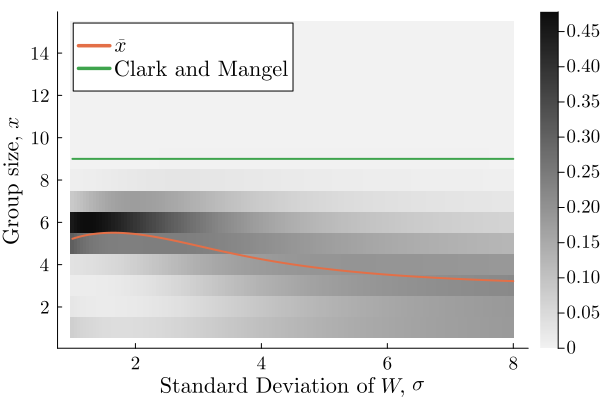

In [53]:
g0 = deepcopy(dg)
g0[1] = 3.0
g0[3] = 2.0
paramkey = :σ

paramvec = collect(1:0.05:8)

hm, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW!, fun_W_gauss; 
    t_f = 500)


savefig(hm, fig_path * "heatmap_L1_phi1.pdf")
hm
plot!(dpi = 100)
#plot!(title=L"Probability heatmap; $x_0 = %$x0$, $a = %$a$")

## Heatmap of fusing vs leaving modulation

Mangel and clark predicted $\hat{x}$ calculated to be 9

### Starting Solitary or in group of 7

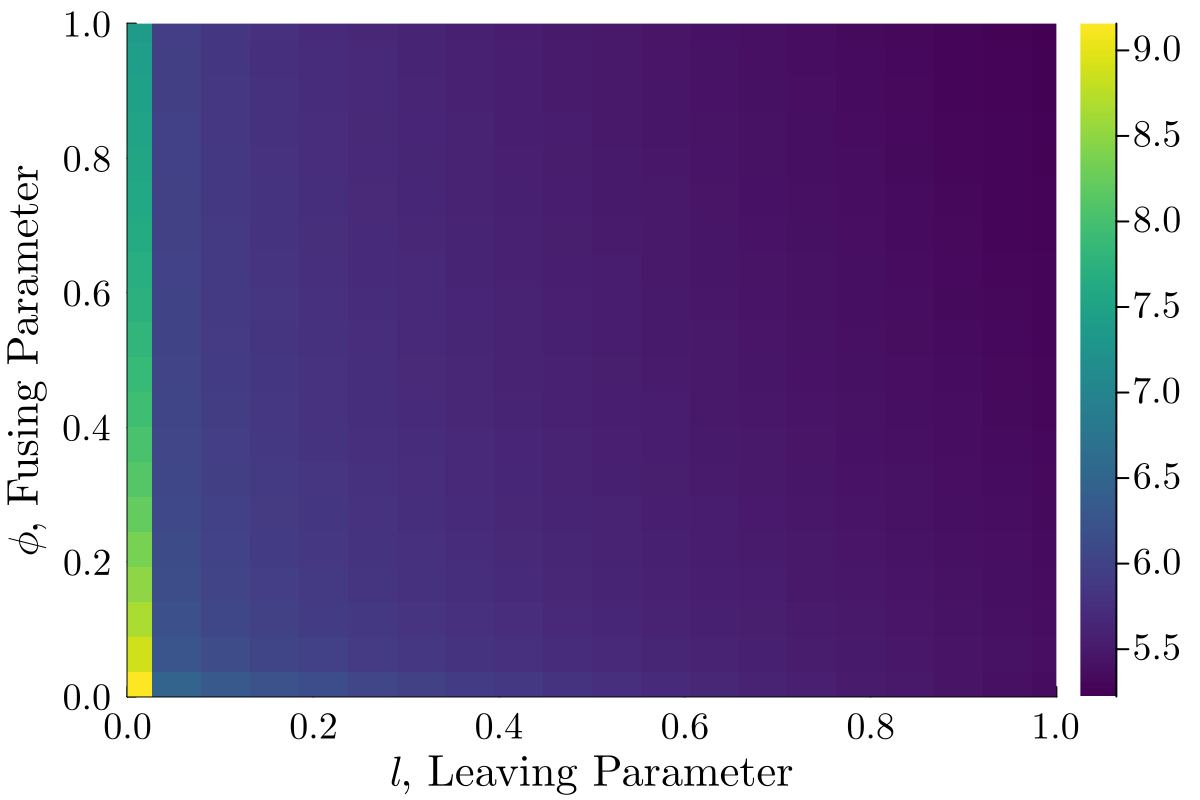

In [54]:
g0 = zeros(params_base[:x_max])
g0[1] = 2.0
g0[7] = 1.0

ODE_fun_handle = fun_dg_simpleW!
hm2, reached_eq, x_mc = plot_hm_modulate_leave_births(g0, params_base, ODE_fun_handle; 
    n = 20, t_f = 50000.0, clims = Nothing, leave_start = 0.0)

hm2

#savefig(hm2, fig_path*"hm_modulate_l_phi.pdf")
#hm2


In [112]:
reached_eq # remember first rows are actually bottom of figure above

20×20 BitMatrix:
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1
 1  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1

### Solitary or in group of 2

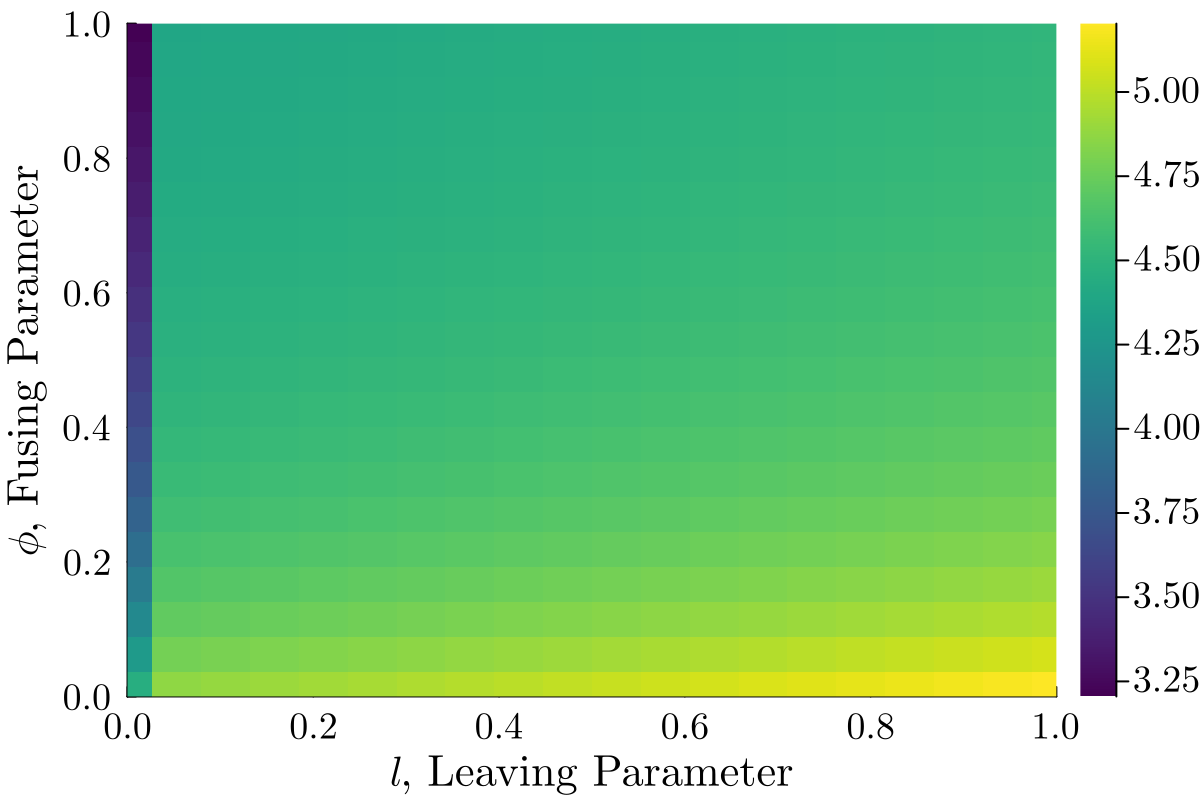

In [114]:
g0 = zeros(params_base[:x_max])
g0[1] = 2.0
g0[2] = 1.0

ODE_fun_handle = fun_dg_simpleW!
hm2, reached_eq, x_mc = plot_hm_modulate_leave_births(g0, params_base, ODE_fun_handle; 
    n = 20, t_f = 1000.0, clims = Nothing, leave_start = 0.0)

savefig(hm2, fig_path*"hm_modulate_l_phi_init2.pdf")
hm2



In [115]:
reached_eq

20×20 BitMatrix:
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1

# With birth and Death

In [116]:
params_base = Dict(
    :a => 2,
    :σ => 1,
    :x0 => 5,
    :Tg => .1,
    :d => 100,
    :x_max => 15,
    :fuse_param => 0.01,
    :leave_param => 0.01
)


Dict{Symbol, Real} with 8 entries:
  :a           => 2
  :Tg          => 0.1
  :x0          => 5
  :σ           => 1
  :d           => 100
  :x_max       => 15
  :leave_param => 0.01
  :fuse_param  => 0.01

### starting: Solitary or in group of 7

Norm(dg) = 2.2e-6. fuse_val = 0.12, leave_val = 0.0 
Norm(dg) = 6.7e-7. fuse_val = 0.23, leave_val = 0.0 
Norm(dg) = 2.3e-6. fuse_val = 0.34, leave_val = 0.0 
Norm(dg) = 1.6e-6. fuse_val = 0.45, leave_val = 0.0 
Norm(dg) = 3.5e-6. fuse_val = 0.56, leave_val = 0.0 
Norm(dg) = 4.4e-6. fuse_val = 0.67, leave_val = 0.0 
Norm(dg) = 2.4e-6. fuse_val = 0.78, leave_val = 0.0 
Norm(dg) = 3.2e-7. fuse_val = 0.89, leave_val = 0.0 
Norm(dg) = 6.8e-8. fuse_val = 1.0, leave_val = 0.0 


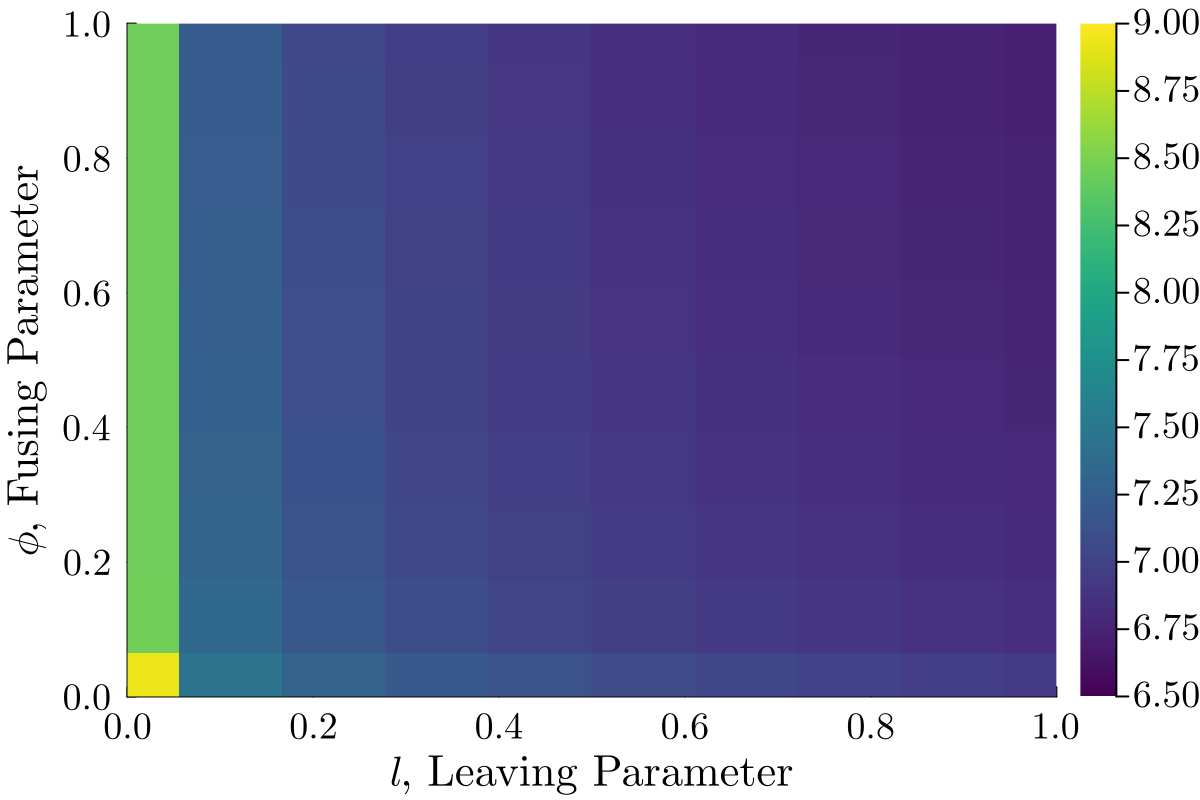

In [117]:
g0 = zeros(params_base[:x_max])
g0[1] = 2.0
g0[7] = 1.0

hm2, reached_eq, x_mc = plot_hm_modulate_leave_births(
    g0, params_base, fun_dg_simpleW_births_constantP!; 
    n = 10, t_f = 5000000.0, 
    leave_start = 0.0,
    clims = (6.5, 9.0))
hm2

In [118]:
reached_eq

10×10 BitMatrix:
 1  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1

### Solitary or in group of 2

Norm(dg) = 1.4e-7. fuse_val = 0.01, leave_val = 0.0 
Norm(dg) = 8.9e-7. fuse_val = 0.12, leave_val = 0.0 
Norm(dg) = 2.2e-6. fuse_val = 0.23, leave_val = 0.0 
Norm(dg) = 2.2e-6. fuse_val = 0.34, leave_val = 0.0 
Norm(dg) = 7.3e-7. fuse_val = 0.45, leave_val = 0.0 
Norm(dg) = 5.3e-7. fuse_val = 0.56, leave_val = 0.0 
Norm(dg) = 3.8e-7. fuse_val = 0.67, leave_val = 0.0 
Norm(dg) = 7.9e-7. fuse_val = 0.78, leave_val = 0.0 
Norm(dg) = 1.5e-8. fuse_val = 0.89, leave_val = 0.0 
Norm(dg) = 4.9e-9. fuse_val = 1.0, leave_val = 0.0 


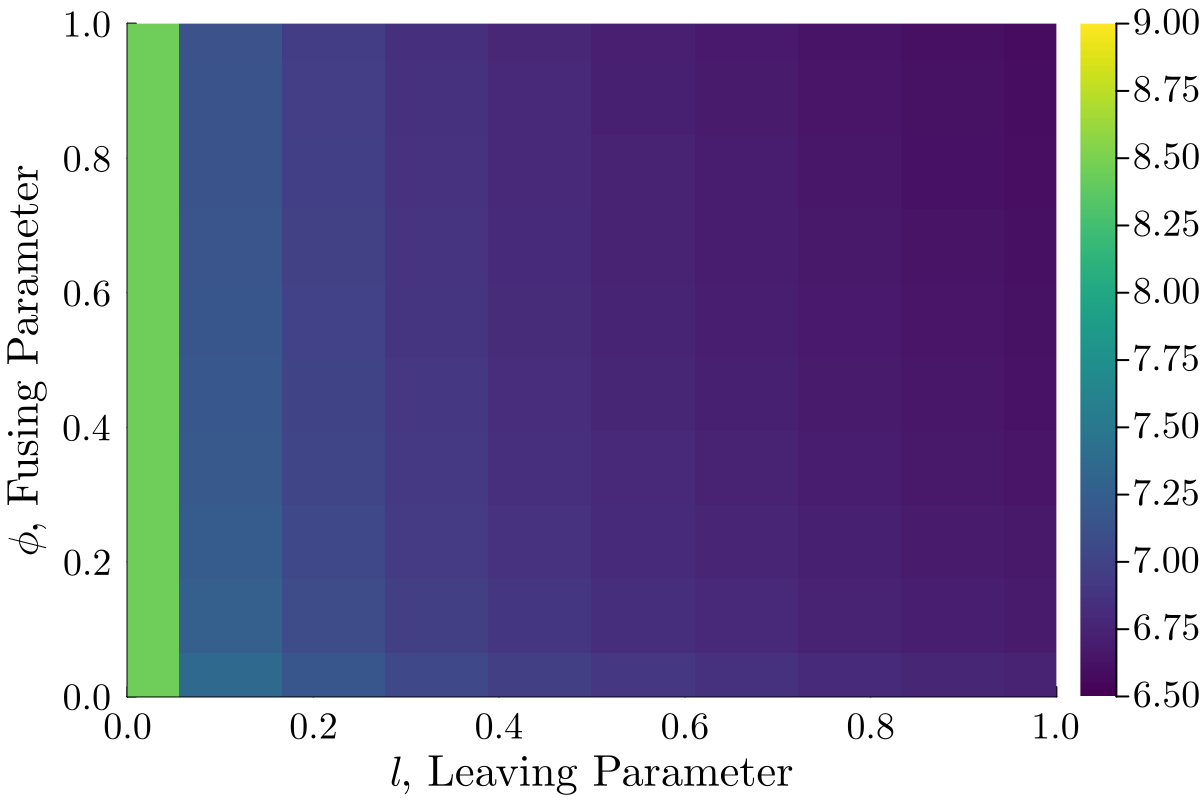

In [119]:
g0 = zeros(params_base[:x_max])
g0[1] = 2.0
g0[2] = 1.0

hm2, reached_eq, x_mc = plot_hm_modulate_leave_births(
    g0, params_base, fun_dg_simpleW_births_constantP!; 
    n = 10, t_f = 5000000.0, leave_start = 0.0,
    clims = (6.5, 9.0))
hm2

In [120]:
reached_eq

10×10 BitMatrix:
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1
 0  1  1  1  1  1  1  1  1  1

Fusing now has very little effect... Except if leaving is zero and fusing is super small, there seems to be multiple equilibria?



# Birth and Death, Vary Tg

1. without leaving or fusing

2. with leaving or fusing

In [123]:
params

Dict{Symbol, Real} with 8 entries:
  :a           => 2
  :Tg          => 1.0
  :x0          => 5
  :σ           => 1
  :d           => 100
  :x_max       => 15
  :leave_param => 0.01
  :fuse_param  => 0.01

Starting with 8 solitaries and 2 groups of 3

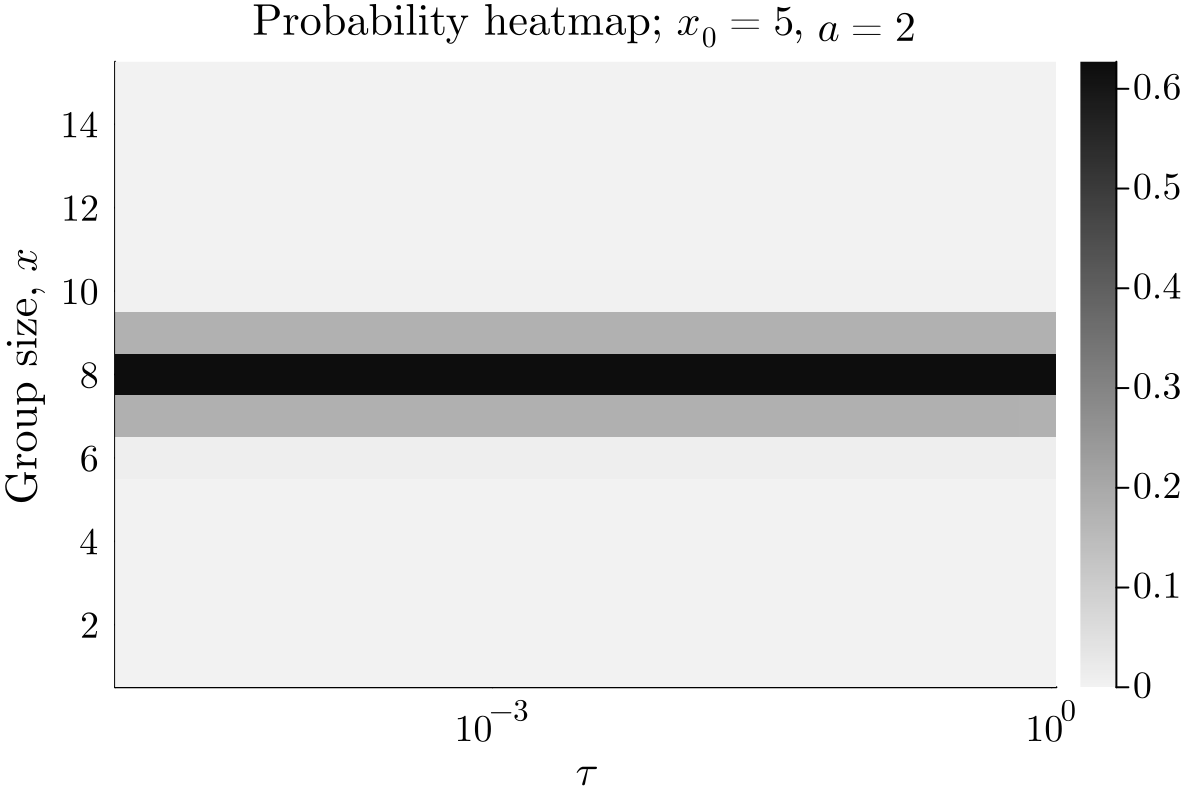

In [131]:
# final Time
t_f = 3000

# turn off fusing and leaving
params = deepcopy(params_base)
params[:fuse_param] = 0.0
params[:leave_param] = 0.0


dg = zeros(params[:x_max])
g0 = deepcopy(dg)
g0[1] = 8.0
g0[3] = 2.0
P = get_p(g0,params[:x_max])
paramkey = :Tg


Tg_exp = collect(-5:0.05:0.0)
paramvec = 10 .^ Tg_exp


n = length(paramvec)
@unpack x_max = params_base

pxmat = zeros(n, x_max)
reached_equilibrium_vec = zeros(n)
mean_x_vec = zeros(n)
mc_x_vec = zeros(n)

for (i,param) in enumerate(paramvec)
    params[paramkey] = param
    prob = ODEProblem(fun_dg_simpleW_births_constantP!, g0, (0,t_f), NamedTuple(params))
    sol = solve(prob);
    g = sol.u;
    g_final = g[end]
    px = get_prob_in_x(g_final, P, x_max)
    pxmat[i,:] = px

    fun_dg_simpleW_births_constantP!(dg, g_final, NamedTuple(params), 1.0)
    reached_equilibrium_vec[i] = all(abs.(dg) .< 1e-10)
    mean_x_vec[i] = get_meanx(g_final, x_max)

    # mangel and Clark
    W = fun_W_gauss(1:x_max, params)
    mc_x_vec[i] = findlast(>=(W[1]),W)
end

@unpack a, x0 = params
hm = heatmap(
        paramvec,     # x = rows
        1:size(pxmat,2),     # y = columns
        pxmat',              # transpose so rows map to x
        c = cgrad(:grays, rev=true),    # high values → dark
        clims = (0.0, findmax(pxmat)[1]), #1.0), 
        #colorrev=false,      # darker = higher
        xlabel=L"$\tau$",
        ylabel=L"Group size, $x$",
        title=L"Probability heatmap; $x_0 = %$x0$, $a = %$a$",
        xscale = :log10
)
#plot!(paramvec, mean_x_vec, label = L"\bar{x}")
#plot!(paramvec, mc_x_vec, label = "Clark and Mangel")
plot!(xscale=:log10)


#hline!([x_mc], label = "Clark and Mangel \nEquilibrium Group Size")


#savefig(hm, fig_path * "heatmap_L1_phi1.pdf")


Starting with 5 solitaries, 1 groups of 3, and 1 group of 6

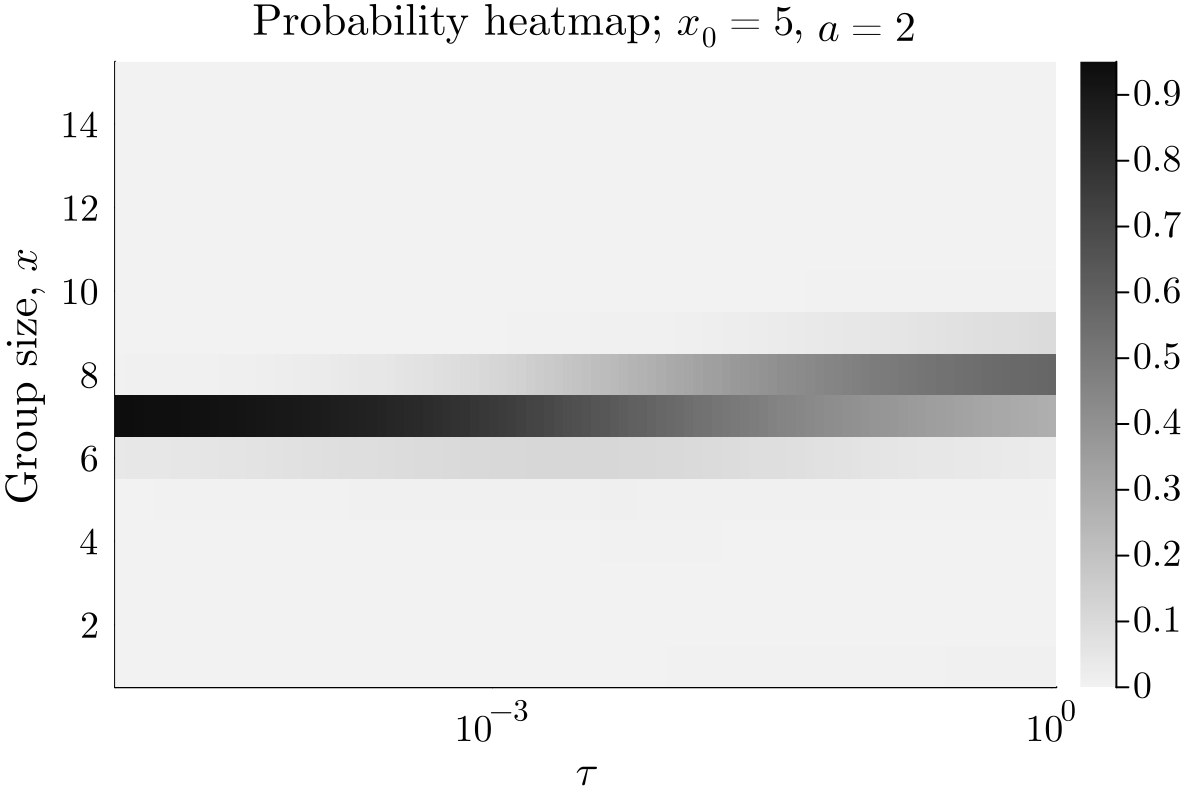

In [ ]:
# final Time
t_f = 3000

# turn off fusing and leaving
params = deepcopy(params_base)
params[:fuse_param] = 0.0
params[:leave_param] = 0.0


dg = zeros(params[:x_max])
g0 = deepcopy(dg)
g0[1] = 5.0
g0[3] = 1.0
g0[6] = 1.0
P = get_p(g0,params[:x_max])
paramkey = :Tg


Tg_exp = collect(-5:0.05:0.0)
paramvec = 10 .^ Tg_exp


n = length(paramvec)
@unpack x_max = params_base

pxmat = zeros(n, x_max)
reached_equilibrium_vec = zeros(n)
mean_x_vec = zeros(n)
mc_x_vec = zeros(n)

for (i,param) in enumerate(paramvec)
    params[paramkey] = param
    prob = ODEProblem(fun_dg_simpleW_births_constantP!, g0, (0,t_f), NamedTuple(params))
    sol = solve(prob);
    g = sol.u;
    g_final = g[end]
    px = get_prob_in_x(g_final, P, x_max)
    pxmat[i,:] = px

    fun_dg_simpleW_births_constantP!(dg, g_final, NamedTuple(params), 1.0)
    reached_equilibrium_vec[i] = all(abs.(dg) .< 1e-10)
    mean_x_vec[i] = get_meanx(g_final, x_max)

    # mangel and Clark
    W = fun_W_gauss(1:x_max, params)
    mc_x_vec[i] = findlast(>=(W[1]),W)
end

@unpack a, x0 = params
hm = heatmap(
        paramvec,     # x = rows
        1:size(pxmat,2),     # y = columns
        pxmat',              # transpose so rows map to x
        c = cgrad(:grays, rev=true),    # high values → dark
        clims = (0.0, findmax(pxmat)[1]), #1.0), 
        #colorrev=false,      # darker = higher
        xlabel=L"$\tau$",
        ylabel=L"Group size, $x$",
        title=L"Probability heatmap; $x_0 = %$x0$, $a = %$a$",
        xscale = :log10
)
#plot!(paramvec, mean_x_vec, label = L"\bar{x}")
#plot!(paramvec, mc_x_vec, label = "Clark and Mangel")
plot!(xscale=:log10)


#hline!([x_mc], label = "Clark and Mangel \nEquilibrium Group Size")


#savefig(hm, fig_path * "heatmap_L1_phi1.pdf")


## Now with a little leaving and fusing

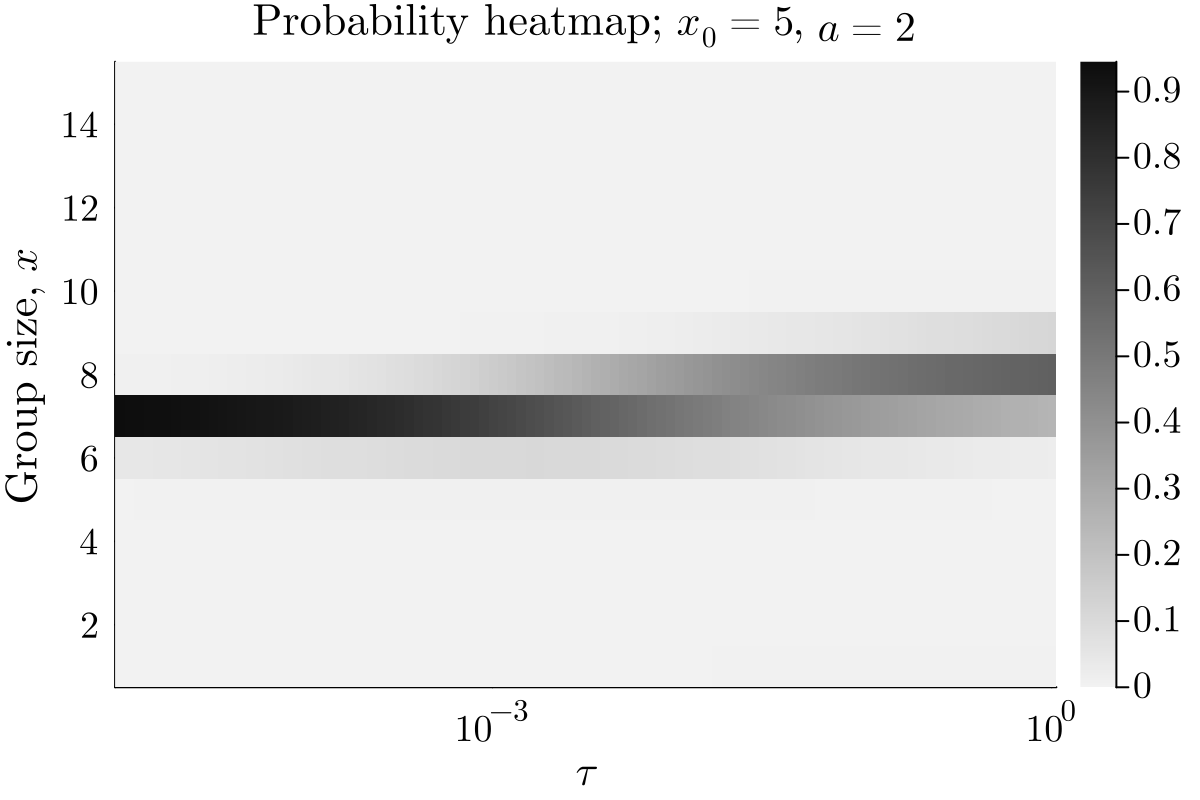

In [137]:
# final Time
t_f = 30000

# turn off fusing and leaving
params = deepcopy(params_base)
params[:fuse_param] = 0.05
params[:leave_param] = 0.05


dg = zeros(params[:x_max])
g0 = deepcopy(dg)
g0[1] = 5.0
g0[3] = 1.0
g0[6] = 1.0
P = get_p(g0,params[:x_max])
paramkey = :Tg


Tg_exp = collect(-5:0.05:0.0)
paramvec = 10 .^ Tg_exp


n = length(paramvec)
@unpack x_max = params_base

pxmat = zeros(n, x_max)
reached_equilibrium_vec = zeros(n)
mean_x_vec = zeros(n)
mc_x_vec = zeros(n)

for (i,param) in enumerate(paramvec)
    params[paramkey] = param
    prob = ODEProblem(fun_dg_simpleW_births_constantP!, g0, (0,t_f), NamedTuple(params))
    sol = solve(prob);
    g = sol.u;
    g_final = g[end]
    px = get_prob_in_x(g_final, P, x_max)
    pxmat[i,:] = px

    fun_dg_simpleW_births_constantP!(dg, g_final, NamedTuple(params), 1.0)
    reached_equilibrium_vec[i] = all(abs.(dg) .< 1e-10)
    mean_x_vec[i] = get_meanx(g_final, x_max)

    # mangel and Clark
    W = fun_W_gauss(1:x_max, params)
    mc_x_vec[i] = findlast(>=(W[1]),W)
end

@unpack a, x0 = params
hm = heatmap(
        paramvec,     # x = rows
        1:size(pxmat,2),     # y = columns
        pxmat',              # transpose so rows map to x
        c = cgrad(:grays, rev=true),    # high values → dark
        clims = (0.0, findmax(pxmat)[1]), #1.0), 
        #colorrev=false,      # darker = higher
        xlabel=L"$\tau$",
        ylabel=L"Group size, $x$",
        title=L"Probability heatmap; $x_0 = %$x0$, $a = %$a$",
        xscale = :log10
)
#plot!(paramvec, mean_x_vec, label = L"\bar{x}")
#plot!(paramvec, mc_x_vec, label = "Clark and Mangel")
plot!(xscale=:log10)


#hline!([x_mc], label = "Clark and Mangel \nEquilibrium Group Size")


#savefig(hm, fig_path * "heatmap_L1_phi1.pdf")


In [139]:
params_base

Dict{Symbol, Real} with 8 entries:
  :a           => 2
  :Tg          => 0.1
  :x0          => 5
  :σ           => 1
  :d           => 100
  :x_max       => 15
  :leave_param => 0.01
  :fuse_param  => 0.01

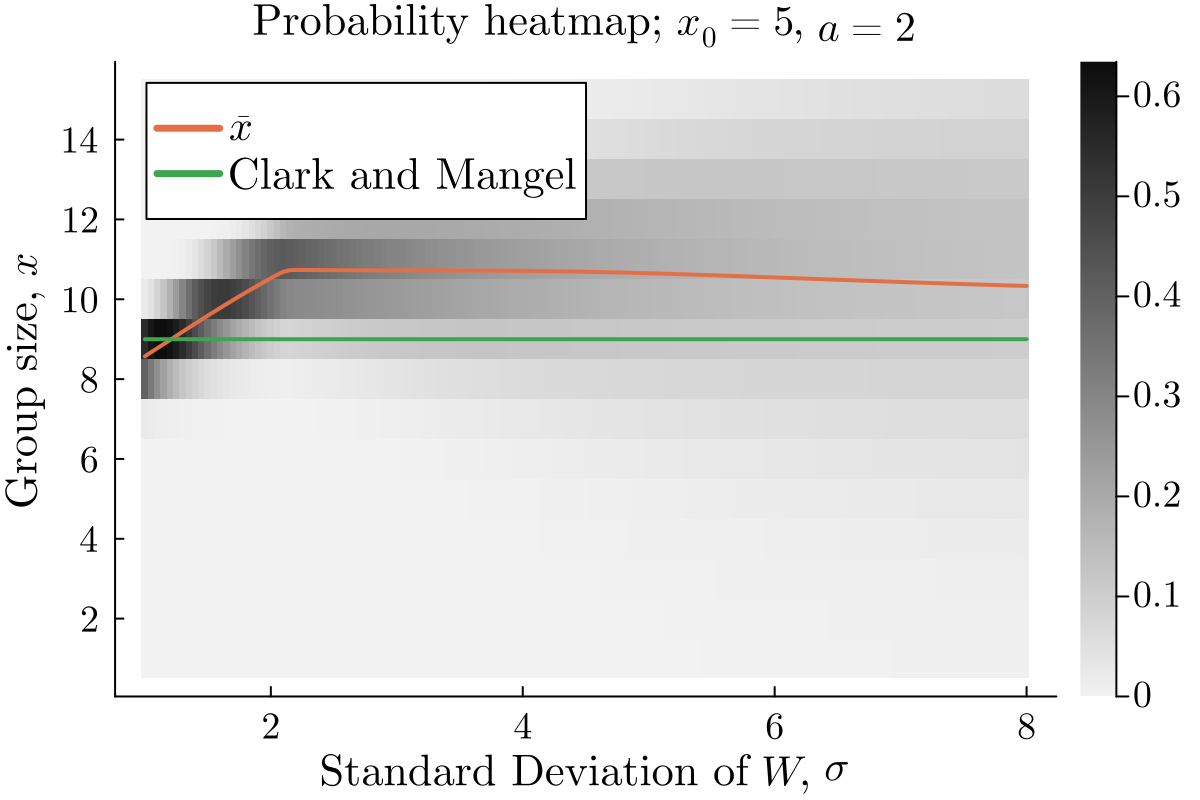

In [181]:
@unpack x0, a = params_base
# turn off fusing and leaving
params_base_noleavefuse = deepcopy(params_base)
params_base_noleavefuse[:fuse_param] = 0
params_base_noleavefuse[:leave_param] = 0
g0 = deepcopy(dg)
g0[1] = 4.0
g0[4] = 2.0
g0[7] = 1.0
paramkey = :σ

paramvec = collect(1:0.05:8)

hm, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base_noleavefuse, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = 5e7 )


#savefig(hm, fig_path * "heatmap_L1_phi1.pdf")
hm
plot!(title=L"Probability heatmap; $x_0 = %$x0$, $a = %$a$")

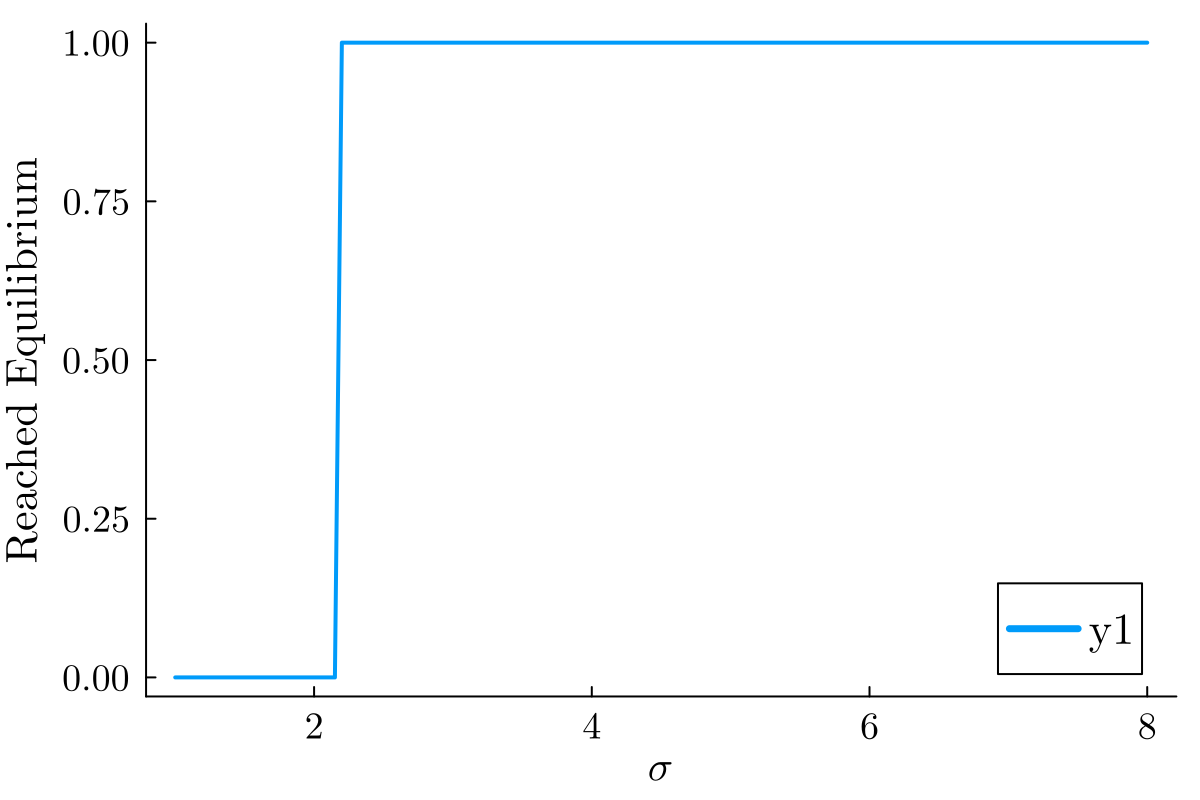

In [186]:
plot(paramvec, reached_equilibrium_vec, xlab = L"\sigma", ylab = "Reached Equilibrium")

In [183]:
findfirst(reached_equilibrium_vec .> 0)

25

In [184]:
paramvec[25]

2.2

In [146]:
reached_equilibrium_vec

141-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

# Four-way figure
1. `fun_dg_simpleW!` with fuse_param, leave_param = 1.0
2. `fun_dg_simpleW!` with fuse_param, leave_param = 0.01
3. `fun_dg_simpleW_births_constantP!` with fuse_param, leave_param = 1.0
4. `fun_dg_simpleW_births_constantP!` with fuse_param, leave_param = 0.01

In [56]:
params_base = Dict(
    :a => 2.0,
    :σ => 1,
    :x0 => 6.0,
    :Tg => .1,
    :d => 5,
    :x_max => 20,
    :leave_param => 1.0,
    :fuse_param => 1.0
)
P = 3.0



3.0

In [57]:
@unpack x_max, x0, a = params_base
paramkey = :σ
t_f = 50000

paramvec = collect(1:0.05:8)

141-element Vector{Float64}:
 1.0
 1.05
 1.1
 1.15
 1.2
 1.25
 1.3
 1.35
 1.4
 1.45
 ⋮
 7.6
 7.65
 7.7
 7.75
 7.8
 7.85
 7.9
 7.95
 8.0

Starting from g = [3.0, 0, 2.0, 0, ..., 0]

In [71]:
g0 = zeros(x_max)
g0[1] = 3.0
g0[3] = 2.0


hm1, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

params_less_leave_fuse = deepcopy(params_base)
params_less_leave_fuse[:leave_param] = 0.01
params_less_leave_fuse[:fuse_param] = 0.01
hm2, reached_equilibrium_vec2 = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

hm3, reached_equilibrium_vec3 = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)


hm4, reached_equilibrium_vec4 = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)



(Plot{Plots.GRBackend() n=3}, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

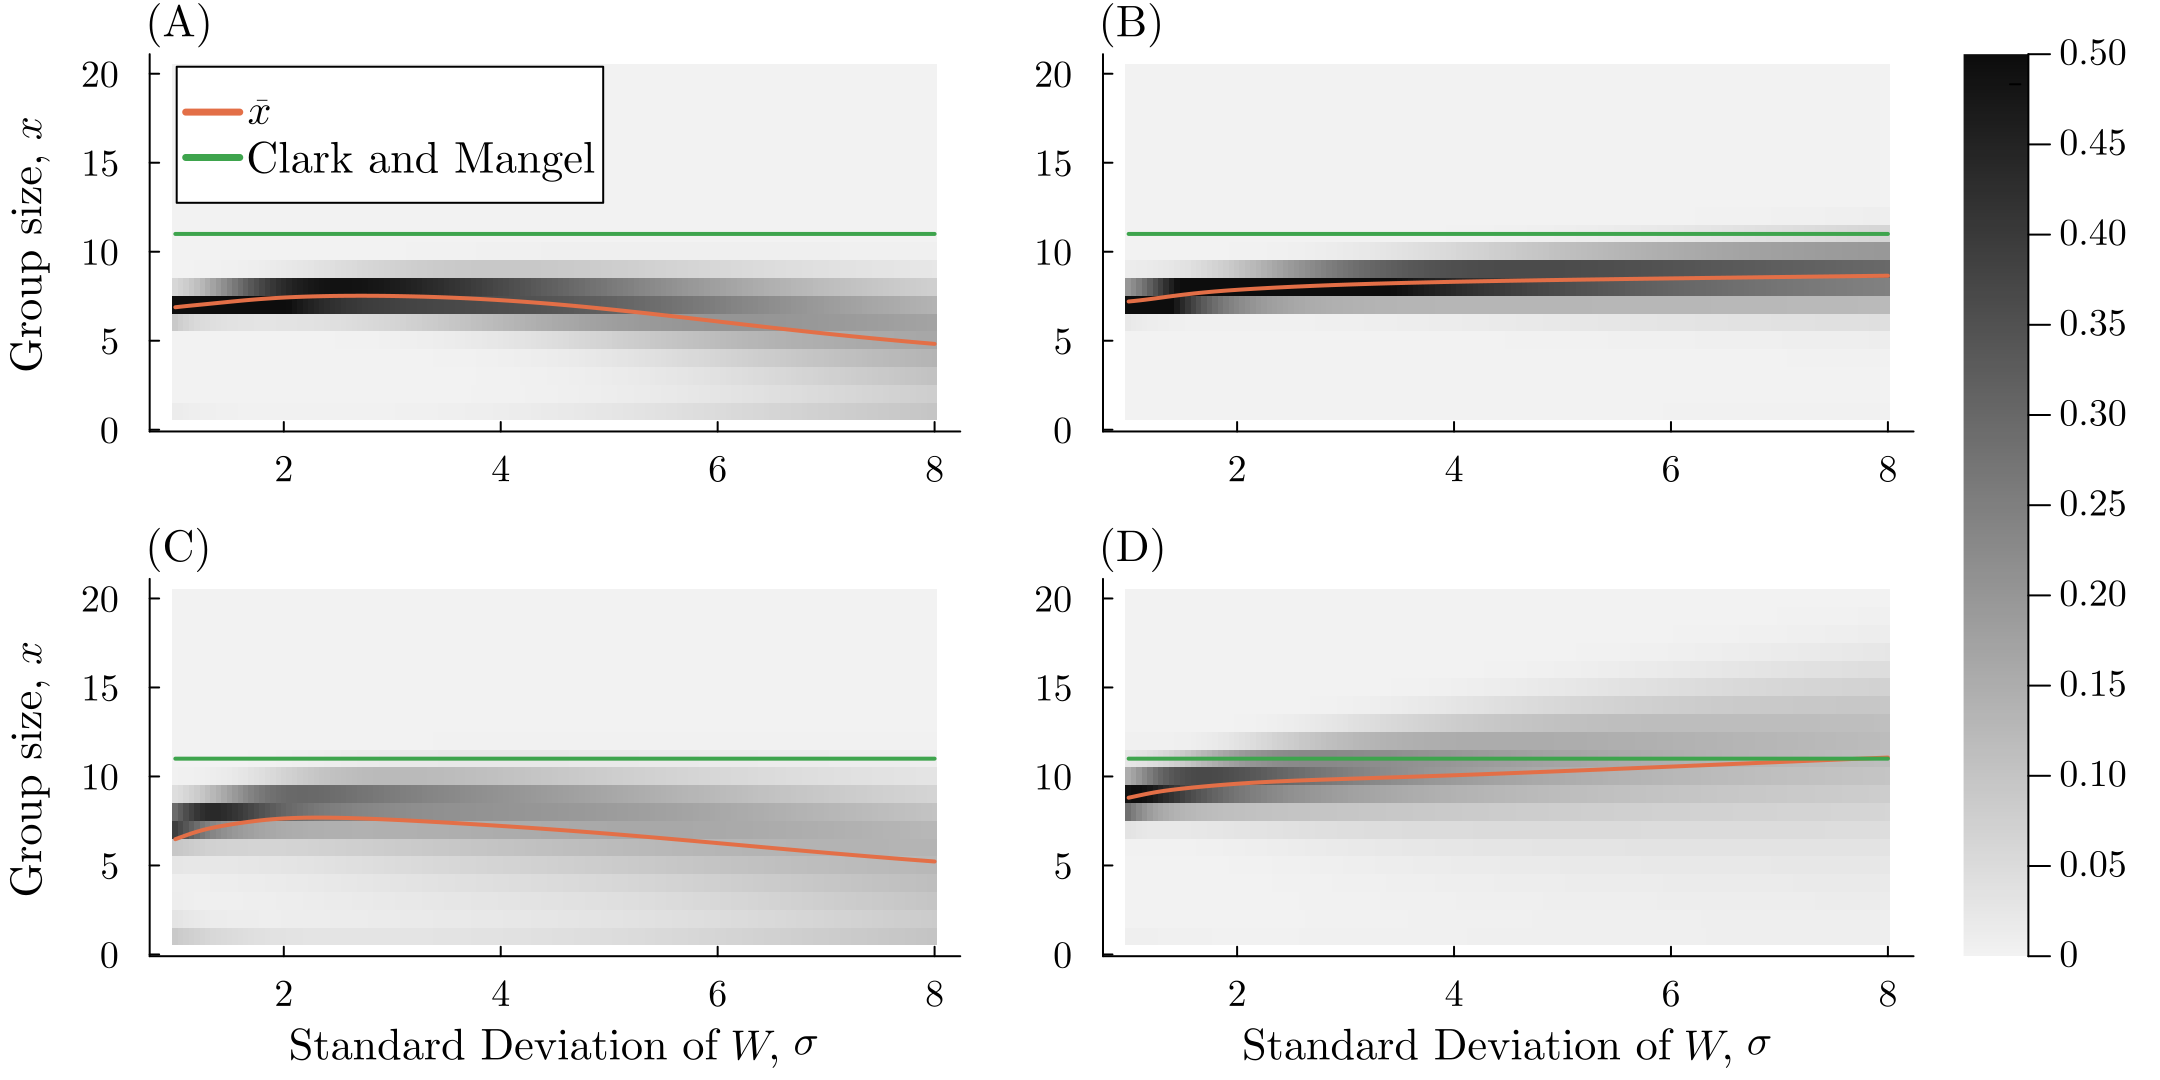

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [72]:
using Measures

clims = (0.0, 0.5)
p1 = plot( 
    plot(hm1; legend = true, xlab = ""),
    plot(hm2; legend = false, xlab = "", ylab = "", right_margin = 5mm),
    plot(hm3; legend = false), 
    plot(hm4; legend = false, ylab = ""); 
    clims = clims, colorbar = false,
    title = ["(A)" "(B)" "(C)" "(D)"], titlelocation = :left,
    titlefonthalign = :left
    )

p_cb = heatmap(fill(NaN, 2, 2); clims, c = cgrad(:grays, rev=true), colorbar=:right,
               framestyle=:none, ticks=false)
#plot!(hm1; legend = true)
p_full = plot(
    p1, p_cb; layout = grid(1, 2, widths=[0.94, 0.06]), size=(1080, 540), 
    bottom_margin = 5mm, left_margin = 5mm,
    )

#savefig(p_full, fig_path * "4heatmaps.pdf")


try a different starting point
g0 = [3, 0, 1, 0, 1, 0, 0, 0, ...]

In [73]:
g0 = zeros(x_max)
g0[1] = 3.0
g0[3] = 1.0
g0[5] = 1.0


hm1, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

params_less_leave_fuse = deepcopy(params_base)
params_less_leave_fuse[:leave_param] = 0.01
params_less_leave_fuse[:fuse_param] = 0.01
hm2, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

hm3, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)


hm4, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)



(Plot{Plots.GRBackend() n=3}, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [75]:
using Measures

clims = (0.0, 0.5)
p1 = plot( 
    plot(hm1; legend = true, xlab = ""),
    plot(hm2; legend = false, xlab = "", ylab = "", right_margin = 5mm),
    plot(hm3; legend = false), 
    plot(hm4; legend = false, ylab = ""); 
    clims = clims, colorbar = false,
    title = ["(A)" "(B)" "(C)" "(D)"], titlelocation = :left,
    titlefonthalign = :left
    )

p_cb = heatmap(fill(NaN, 2, 2); clims, c = cgrad(:grays, rev=true), colorbar=:right,
               framestyle=:none, ticks=false)
#plot!(hm1; legend = true)
p_full = plot(
    p1, p_cb; layout = grid(1, 2, widths=[0.94, 0.06]), size=(1080, 540), 
    bottom_margin = 5mm, left_margin = 5mm,
    )

savefig(p_full, fig_path * "4heatmaps.pdf")


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/SimpleW/4heatmaps.pdf"

## Vary a

In [76]:
@unpack x_max, x0, σ = params_base
paramkey = :a
t_f = 50000

paramvec = collect(1:0.05:3)

41-element Vector{Float64}:
 1.0
 1.05
 1.1
 1.15
 1.2
 1.25
 1.3
 1.35
 1.4
 1.45
 ⋮
 2.6
 2.65
 2.7
 2.75
 2.8
 2.85
 2.9
 2.95
 3.0

In [77]:
params_base

Dict{Symbol, Real} with 8 entries:
  :a           => 2.0
  :Tg          => 0.1
  :x0          => 6.0
  :σ           => 1
  :d           => 5
  :x_max       => 20
  :leave_param => 1.0
  :fuse_param  => 1.0

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


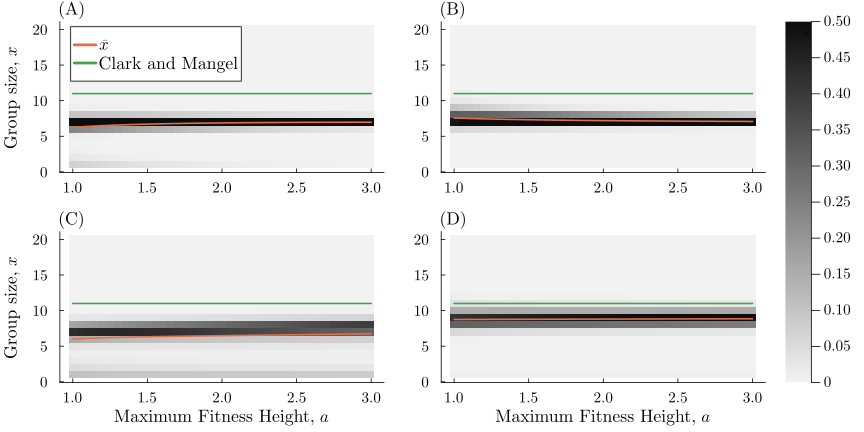

In [79]:
g0 = zeros(x_max)
g0[1] = 3.0
g0[3] = 2.0
paramkey = :a

hm1, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

params_less_leave_fuse = deepcopy(params_base)
params_less_leave_fuse[:leave_param] = 0.01
params_less_leave_fuse[:fuse_param] = 0.01
hm2, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

hm3, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)


hm4, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)

clims = (0.0, 0.5)
p1 = plot( 
    plot(hm1; legend = true, xlab = ""),
    plot(hm2; legend = false, xlab = "", ylab = "", right_margin = 5mm),
    plot(hm3; legend = false), 
    plot(hm4; legend = false, ylab = ""); 
    clims = clims, colorbar = false,
    title = ["(A)" "(B)" "(C)" "(D)"], titlelocation = :left,
    titlefonthalign = :left
    )

p_cb = heatmap(fill(NaN, 2, 2); clims, c = cgrad(:grays, rev=true), colorbar=:right,
               framestyle=:none, ticks=false)
#plot!(hm1; legend = true)
p_full = plot(
    p1, p_cb; layout = grid(1, 2, widths=[0.94, 0.06]), size=(1080, 540), 
    bottom_margin = 5mm, left_margin = 5mm,
    )

savefig(p_full, fig_path * "4heatmaps_a.pdf")
p_full
plot!(dpi = 80)



Different starting point

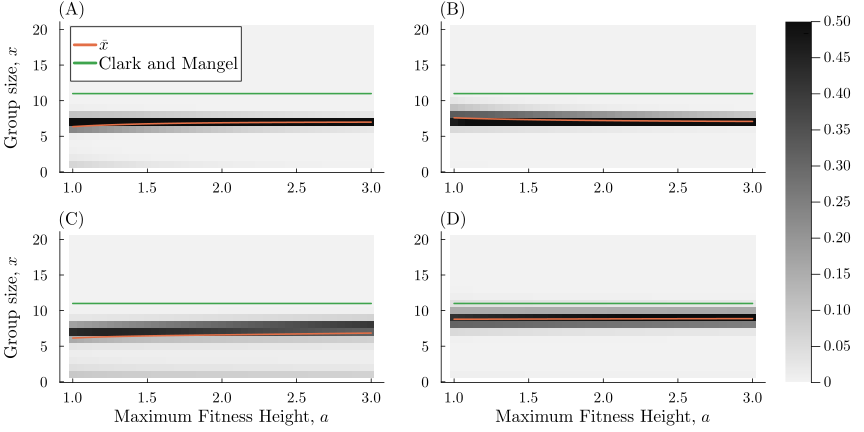

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [80]:
g0 = zeros(x_max)
g0[1] = 3.0
g0[3] = 1.0
g0[5] = 1.0
paramkey = :a

hm1, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

params_less_leave_fuse = deepcopy(params_base)
params_less_leave_fuse[:leave_param] = 0.01
params_less_leave_fuse[:fuse_param] = 0.01
hm2, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

hm3, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)


hm4, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)

clims = (0.0, 0.5)
p1 = plot( 
    plot(hm1; legend = true, xlab = ""),
    plot(hm2; legend = false, xlab = "", ylab = "", right_margin = 5mm),
    plot(hm3; legend = false), 
    plot(hm4; legend = false, ylab = ""); 
    clims = clims, colorbar = false,
    title = ["(A)" "(B)" "(C)" "(D)"], titlelocation = :left,
    titlefonthalign = :left
    )

p_cb = heatmap(fill(NaN, 2, 2); clims, c = cgrad(:grays, rev=true), colorbar=:right,
               framestyle=:none, ticks=false)
#plot!(hm1; legend = true)
p_full = plot(
    p1, p_cb; layout = grid(1, 2, widths=[0.94, 0.06]), size=(1080, 540), 
    bottom_margin = 5mm, left_margin = 5mm,
    )

#savefig(p_full, fig_path * "4heatmaps_a.pdf")

plot!(dpi = 80)


## Vary x0

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


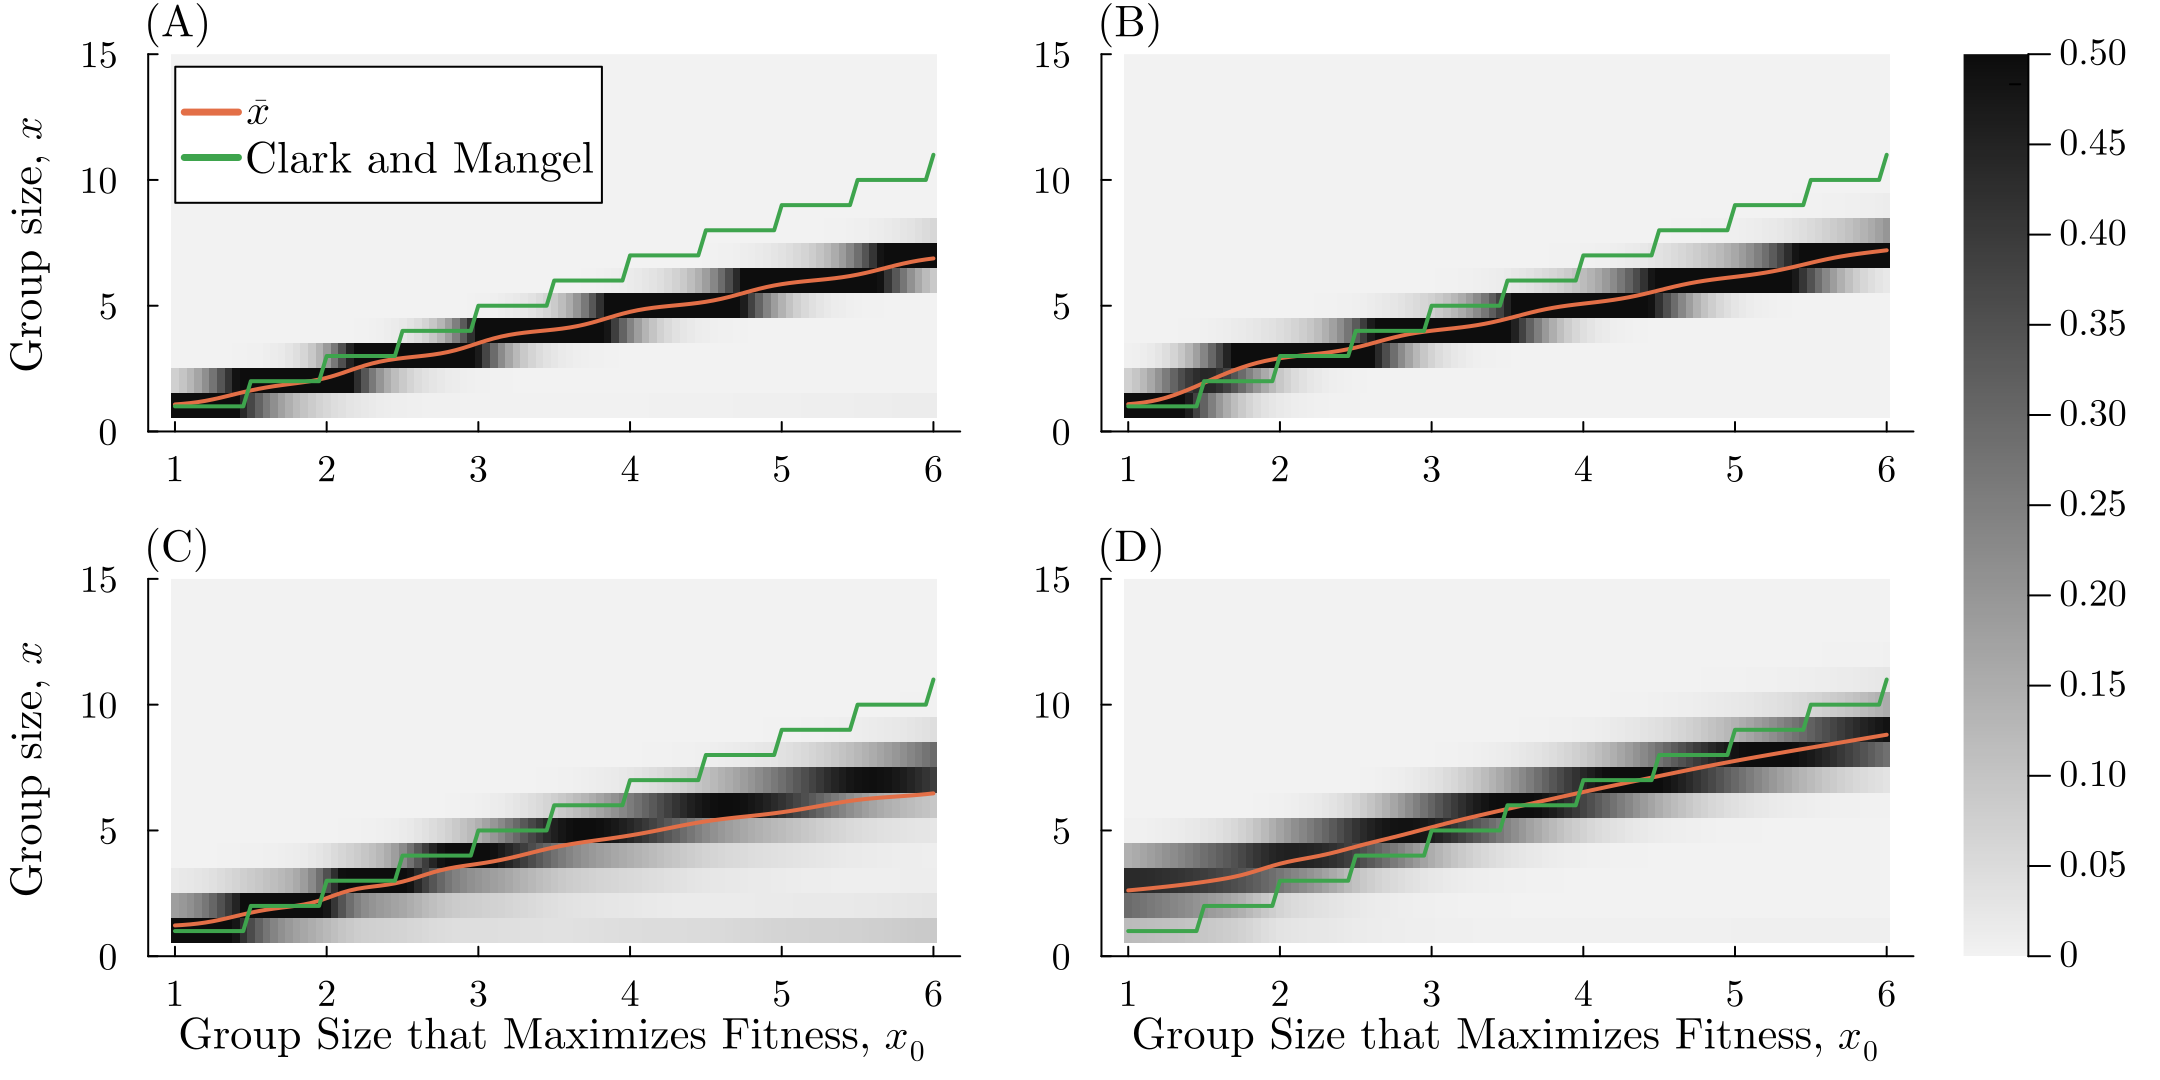

In [81]:
@unpack x_max, x0, σ = params_base
paramkey = :x0
t_f = 50000

paramvec = collect(1:0.05:6)

g0 = zeros(x_max)
g0[1] = 3.0
g0[3] = 2.0


hm1, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

params_less_leave_fuse = deepcopy(params_base)
params_less_leave_fuse[:leave_param] = 0.01
params_less_leave_fuse[:fuse_param] = 0.01
hm2, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

hm3, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)


hm4, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)



clims = (0.0, 0.5)
p1 = plot( 
    plot(hm1; legend = true, xlab = ""),
    plot(hm2; legend = false, xlab = "", ylab = "", right_margin = 5mm),
    plot(hm3; legend = false), 
    plot(hm4; legend = false, ylab = ""); 
    clims = clims, colorbar = false,
    title = ["(A)" "(B)" "(C)" "(D)"], titlelocation = :left,
    titlefonthalign = :left,
    ylims = (0,15)
    )

p_cb = heatmap(fill(NaN, 2, 2); clims, c = cgrad(:grays, rev=true), colorbar=:right,
               framestyle=:none, ticks=false)
#plot!(hm1; legend = true)
p_full = plot(
    p1, p_cb; layout = grid(1, 2, widths=[0.94, 0.06]), size=(1080, 540), 
    bottom_margin = 5mm, left_margin = 5mm,
    )

savefig(p_full, fig_path * "4heatmaps_x0.pdf")
p_full


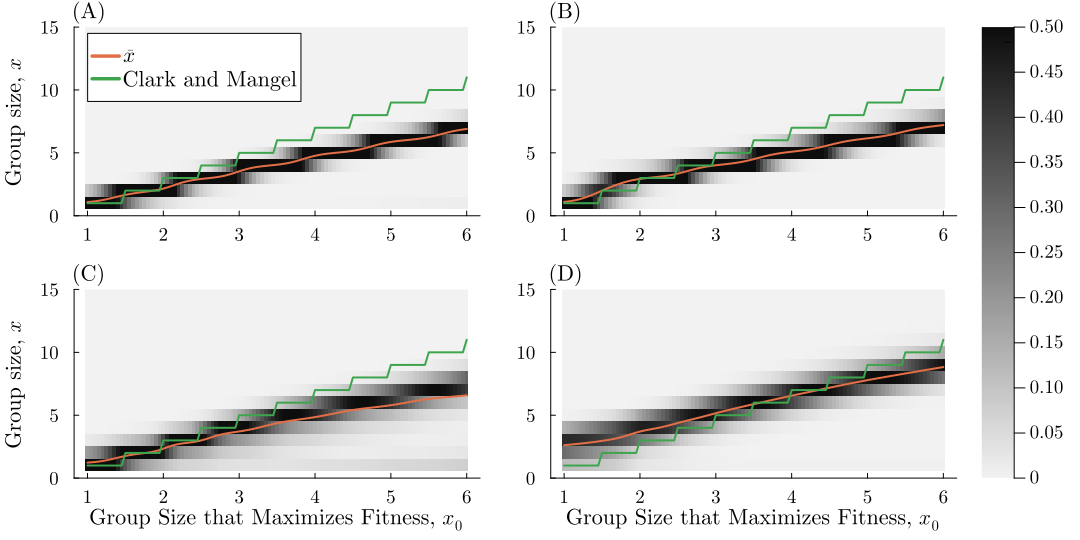

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [82]:
@unpack x_max, x0, σ = params_base
paramkey = :x0
t_f = 50000

paramvec = collect(1:0.05:6)

g0 = zeros(x_max)
g0[1] = 3.0
g0[3] = 1.0
g0[5] = 1.0


hm1, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

params_less_leave_fuse = deepcopy(params_base)
params_less_leave_fuse[:leave_param] = 0.01
params_less_leave_fuse[:fuse_param] = 0.01
hm2, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW!, fun_W_gauss; 
    t_f = t_f)

hm3, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_base, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)


hm4, reached_equilibrium_vec = make_hm_versus_param(
    g0, paramkey, paramvec, params_less_leave_fuse, fun_dg_simpleW_births_constantP!, fun_W_gauss; 
    t_f = t_f)



clims = (0.0, 0.5)
p1 = plot( 
    plot(hm1; legend = true, xlab = ""),
    plot(hm2; legend = false, xlab = "", ylab = "", right_margin = 5mm),
    plot(hm3; legend = false), 
    plot(hm4; legend = false, ylab = ""); 
    clims = clims, colorbar = false,
    title = ["(A)" "(B)" "(C)" "(D)"], titlelocation = :left,
    titlefonthalign = :left,
    ylims = (0,15)
    )

p_cb = heatmap(fill(NaN, 2, 2); clims, c = cgrad(:grays, rev=true), colorbar=:right,
               framestyle=:none, ticks=false)
#plot!(hm1; legend = true)
p_full = plot(
    p1, p_cb; layout = grid(1, 2, widths=[0.94, 0.06]), size=(1080, 540), 
    bottom_margin = 5mm, left_margin = 5mm,
    )
plot!(dpi = 100)

#savefig(p_full, fig_path * "4heatmaps_x0.pdf")


In [174]:
params_base

Dict{Symbol, Real} with 8 entries:
  :a           => 2.0
  :Tg          => 0.1
  :x0          => 6.0
  :σ           => 1
  :d           => 5
  :x_max       => 20
  :leave_param => 1.0
  :fuse_param  => 1.0

In [137]:
params_base[:d]

2